# Tuning a scikit-learn estimator with `skopt`

Gilles Louppe, July 2016 <br />
Katie Malone, August 2016

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)

## Problem statement

Tuning the hyper-parameters of a machine learning model is often carried out using an exhaustive exploration of (a subset of) the space all hyper-parameter configurations (e.g., using `sklearn.model_selection.GridSearchCV`), which often results in a very time consuming operation. 

In this notebook, we illustrate how `skopt` can be used to tune hyper-parameters using sequential model-based optimisation, hopefully resulting in equivalent or better solutions, but within less evaluations.

## Objective 

The first step is to define the objective function we want to minimize, in this case the cross-validation mean absolute error of a gradient boosting regressor over the Boston dataset, as a function of its hyper-parameters:

In [2]:
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

boston = load_boston()
X, y = boston.data, boston.target
n_features = X.shape[1]
reg = GradientBoostingRegressor(n_estimators=50, random_state=0)

def objective(params):
    max_depth, learning_rate, max_features, min_samples_split, min_samples_leaf = params

    reg.set_params(max_depth=max_depth,
                   learning_rate=learning_rate,
                   max_features=max_features,
                   min_samples_split=min_samples_split, 
                   min_samples_leaf=min_samples_leaf)

    return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

Next, we need to define the bounds of the dimensions of the search space we want to explore, and (optionally) the starting point:

In [3]:
space  = [(1, 5),                           # max_depth
          (10**-5, 10**-1, "log-uniform"),  # learning_rate
          (1, n_features),                  # max_features
          (2, 30),                          # min_samples_split
          (1, 30)]                          # min_samples_leaf

x0 = [3, 0.01, 6, 2, 1]

## Optimize all the things!

With these two pieces, we are now ready for sequential model-based optimisation. Here we compare gaussian process-based optimisation versus forest-based optimisation.

In [4]:
from skopt import gp_minimize
res_gp = gp_minimize(objective, space, x0=x0, n_calls=50, random_state=0, n_random_starts=0)

"Best score=%.4f" % res_gp.fun

'Best score=2.9307'

In [5]:
print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4]))

Best parameters:
- max_depth=4
- learning_rate=0.096450
- max_features=10
- min_samples_split=30
- min_samples_leaf=2


In [6]:
from skopt import forest_minimize
res_forest = forest_minimize(objective, space, x0=x0, n_calls=50, random_state=0, n_random_starts=0)

"Best score=%.4f" % res_forest.fun

'Best score=2.8855'

In [7]:
print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_forest.x[0], res_forest.x[1], 
                            res_forest.x[2], res_forest.x[3], 
                            res_forest.x[4]))

Best parameters:
- max_depth=4
- learning_rate=0.072758
- max_features=7
- min_samples_split=7
- min_samples_leaf=1


As a baseline, let us also compare with random search in the space of hyper-parameters, which is equivalent to `sklearn.model_selection.RandomizedSearchCV`.

In [8]:
from skopt import dummy_minimize
res_dummy = dummy_minimize(objective, space, x0=x0, n_calls=50, random_state=0)

"Best score=%.4f" % res_dummy.fun

'Best score=3.0592'

In [9]:
print("""Best parameters:
- max_depth=%d
- learning_rate=%.4f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_dummy.x[0], res_dummy.x[1], 
                            res_dummy.x[2], res_dummy.x[3], 
                            res_dummy.x[4]))

Best parameters:
- max_depth=5
- learning_rate=0.0596
- max_features=10
- min_samples_split=23
- min_samples_leaf=1


## Convergence plot

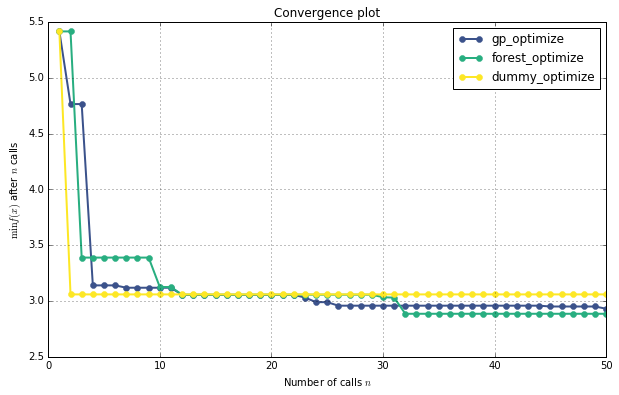

In [10]:
from skopt.plots import plot_convergence
plot_convergence(("gp_optimize", res_gp),
                 ("forest_optimize", res_forest),
                 ("dummy_optimize", res_dummy))

## Part 2: Tuning a scikit-learn pipeline with `skopt`

### Introduction

Scikit-learn objects (transformers, estimators) are often not used singly, but instead chained together into a <a href="http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html">pipeline</a>.  When that happens, there can be several different sets of hyperparameters to examine, one for each object.  In the same way that `GridSearchCV` can be applied to a pipeline to tune the hyperparameters of several objects at once, we can do a more efficient search (this example uses GPs) over more than one scikit-learn object.

A common technique to deal with high-dimensional data is to do some feature-selection before using your tree-based models. Here we use the mutual information feature selector to tune the number of features to input into the gradient booster. An advantage being that it can handle both discrete and continuous features

In [11]:
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_regression

mutual_info_regression = partial(mutual_info_regression, discrete_features=[3, 7])
skb = SelectKBest(mutual_info_regression, k=5)

reg_pipe = GradientBoostingRegressor(n_estimators=50, random_state=0)
pipe = Pipeline([('skb', skb), ('reg', reg_pipe)])

### Defining the search space

Our parameter space has dimensions for the n_components parameter of PCA, as well as several parameters of the decision tree.
Optionally, we can also define a starting point for the search.

In [12]:
pipe_space  = [(1, X.shape[1]),             # n_components of PCA
          (1, 5),                           # max_depth of GBR
          (10**-5, 10**-1, "log-uniform"),  # learning_rate of GBR
          (1, 20),                          # max_features of GBR
          (2, 30),                          # min_samples_split of GBR
          (1, 30)]                          # min_samples_leaf of GBR


pipe_x0 = [n_features] + x0   # optional starting point

The updated objective function (which I've named `objective_pipe`) is very similar to the objective function that we've had before, except now there are two places where parameters get set--we're changing the parameters of both `skb` and `reg` at the same time.

In [13]:
def objective_pipe(params):
    k, max_depth,\
    learning_rate, max_features,\
    min_samples_split, min_samples_leaf = params
    
    # If the max_features returned by the minimization objective
    # is greater than k
    max_features = min(max_features, k)

    # set number of features to select
    pipe.set_params(skb__k=k)

    # set decision tree classifier parameters
    pipe.set_params(reg__max_depth=max_depth,
                    reg__learning_rate=learning_rate,
                    reg__max_features=max_features,
                    reg__min_samples_split=min_samples_split,
                    reg__min_samples_leaf=min_samples_leaf)

    error = -np.mean(cross_val_score(pipe, X, y, cv=5, n_jobs=-1,
                                     scoring="neg_mean_absolute_error"))
    return error

### Optimize all the things, again!

Again, things are analagous with the example above, except we're running with the pipeline-specific objective function and parameter options.

In [14]:
import warnings
warnings.filterwarnings("ignore") # this minimize call issues a lot of warnings--quiet them
                                  # associated scikit-learn issue #6746

print(pipe_x0)
pipe_res_gp = gp_minimize(objective_pipe, pipe_space, x0=pipe_x0, n_calls=50, random_state=0, n_random_starts=0)
print("Best score=%.4f" % pipe_res_gp.fun)
print("""Best parameters:
    - n_components=%d
    - max_depth=%d
    - learning_rate=%.6f
    - max_features=%d
    - min_samples_split=%d
    - min_samples_leaf=%d""" % (pipe_res_gp.x[0], pipe_res_gp.x[1],
                                pipe_res_gp.x[2], min(pipe_res_gp.x[3], pipe_res_gp.x[0]),
                                pipe_res_gp.x[4], pipe_res_gp.x[5]))

[13, 3, 0.01, 6, 2, 1]
Best score=2.9451
Best parameters:
    - n_components=13
    - max_depth=3
    - learning_rate=0.091824
    - max_features=13
    - min_samples_split=16
    - min_samples_leaf=3


We've started with a gaussian process algorithm; now add dummy and forest minimization functions to get a survey of the field.

In [15]:
pipe_res_dummy = dummy_minimize(objective_pipe, pipe_space, x0=pipe_x0, n_calls=50, random_state=0)
print("Best score=%.4f" % pipe_res_dummy.fun)
print("""Best parameters:
    - n_components=%d
    - max_depth=%d
    - learning_rate=%.6f
    - max_features=%d
    - min_samples_split=%d
    - min_samples_leaf=%d""" % (pipe_res_dummy.x[0], pipe_res_dummy.x[1],
                                pipe_res_dummy.x[2], min(pipe_res_dummy.x[3], pipe_res_dummy.x[0]),
                                pipe_res_dummy.x[4], pipe_res_dummy.x[5]))

Best score=3.1216
Best parameters:
    - n_components=8
    - max_depth=3
    - learning_rate=0.064714
    - max_features=8
    - min_samples_split=30
    - min_samples_leaf=17


In [16]:
from skopt import forest_minimize
pipe_res_forest = forest_minimize(objective_pipe, pipe_space, x0=pipe_x0, n_calls=50, random_state=0, n_random_starts=0)
print("Best score=%.4f" % pipe_res_forest.fun)
print("""Best parameters:
    - n_components=%d
    - max_depth=%d
    - learning_rate=%.6f
    - max_features=%d
    - min_samples_split=%d
    - min_samples_leaf=%d""" % (pipe_res_forest.x[0], pipe_res_forest.x[1],
                                pipe_res_forest.x[2], min(pipe_res_forest.x[3], pipe_res_forest.x[0]),
                                pipe_res_forest.x[4], pipe_res_forest.x[5]))

Best score=2.9611
Best parameters:
    - n_components=12
    - max_depth=3
    - learning_rate=0.093084
    - max_features=10
    - min_samples_split=20
    - min_samples_leaf=1


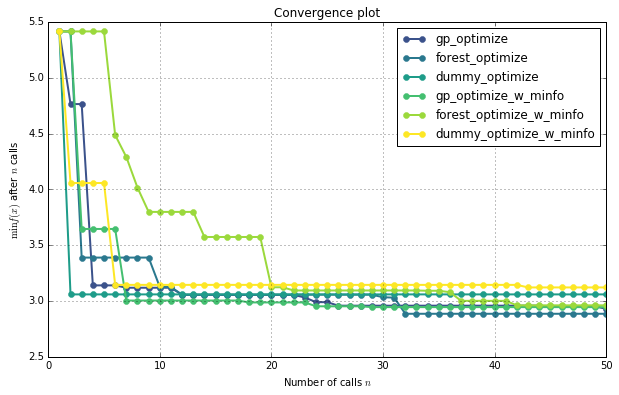

In [17]:
plot_convergence(("gp_optimize", res_gp),
                 ("forest_optimize", res_forest),
                 ("dummy_optimize", res_dummy),
                 ("gp_optimize_w_minfo", pipe_res_gp),
                 ("forest_optimize_w_minfo", pipe_res_forest),
                 ("dummy_optimize_w_minfo", pipe_res_dummy))

So, interestingly, our pipelines do not seem to do much better than the regressors themselves. This could mean that there is enough data to prevent the model from overfitting, hence we do not gain a lot by doing feature selection.  